#  Cheapest day before a flight to buy tickets prediction - Iteration 1

In [1]:
import sklearn
import pandas as pd
import seaborn
import numpy as np
from matplotlib import pyplot as plt
import glob
import seaborn as sns
import matplotlib.pyplot as plt


# 📦 Data provisioning
The flights is gathered from **google flights**, using a *webscraper*. It includes data from the routes **SOF-EIN** , **EIN-SOF** , **EIN-ATH** , **ISTANBUL-AMS** , **MUNICH - NEW YORK**. The dataset includes data from **03.2025 - 12.2025**

In [2]:
main_data = pd.read_csv('./datasets/finalized_dataset.csv')


# 📃 Sample the data


In [3]:
main_data.sample(10)

,daysAgo,price,departure_airport,arrival_airport,airport_distance_km,airline_Aegean,airline_Delta,airline_Other,airline_Pegasus,airline_Republic American,airline_Ryanair,airline_Transavia,airline_Turkish Airlines,airline_Wizzair,departure_date_unix,record_timestamp_unix,near_holiday_-1.0,near_holiday_0.0,near_holiday_1.0,cheapest_day_future
19196,102,44,1,4,328.393017,0,0,0,0,1,0,0,0,0,1748390400,1739577600,False,False,True,82
13148,53,46,0,3,1658.335311,0,0,0,0,0,1,0,0,0,1746662400,1742083200,False,False,True,49
41257,193,64,0,3,1658.335311,0,0,0,0,0,1,0,0,0,1754784000,1738108800,False,True,False,180
51625,219,112,3,0,2211.947562,0,0,0,1,0,0,0,0,0,1757721600,1738800000,False,False,True,177
1459,58,61,1,4,328.393017,0,1,0,0,0,0,0,0,0,1743206400,1738195200,False,False,False,20
51966,180,129,3,0,2211.947562,0,0,0,0,0,0,0,1,0,1757808000,1742256000,False,False,False,180
16826,117,59,2,2,1658.335311,0,0,0,0,0,1,0,0,0,1747699200,1737590400,True,False,False,96
3530,39,114,0,3,1658.335311,0,0,0,0,0,0,0,0,1,1743811200,1740441600,False,False,False,31
48791,214,91,1,4,328.393017,0,1,0,0,0,0,0,0,0,1756944000,1738454400,False,False,True,180
18506,69,132,0,1,2067.423123,1,0,0,0,0,0,0,0,0,1748217600,1742256000,False,False,True,69


In [4]:
main_data.drop(columns=['daysAgo'], inplace=True)

# 🛠️ Preprocessing 

The dataset has already been preprocessed in the previous iterations

## 🎯 Target Variable


First, as the algorhitm is categorical, we need to convert the target variable into a category.

### 💡 Feature Selection

Now we will create several graphs to visualize relationships between the features of the dataset


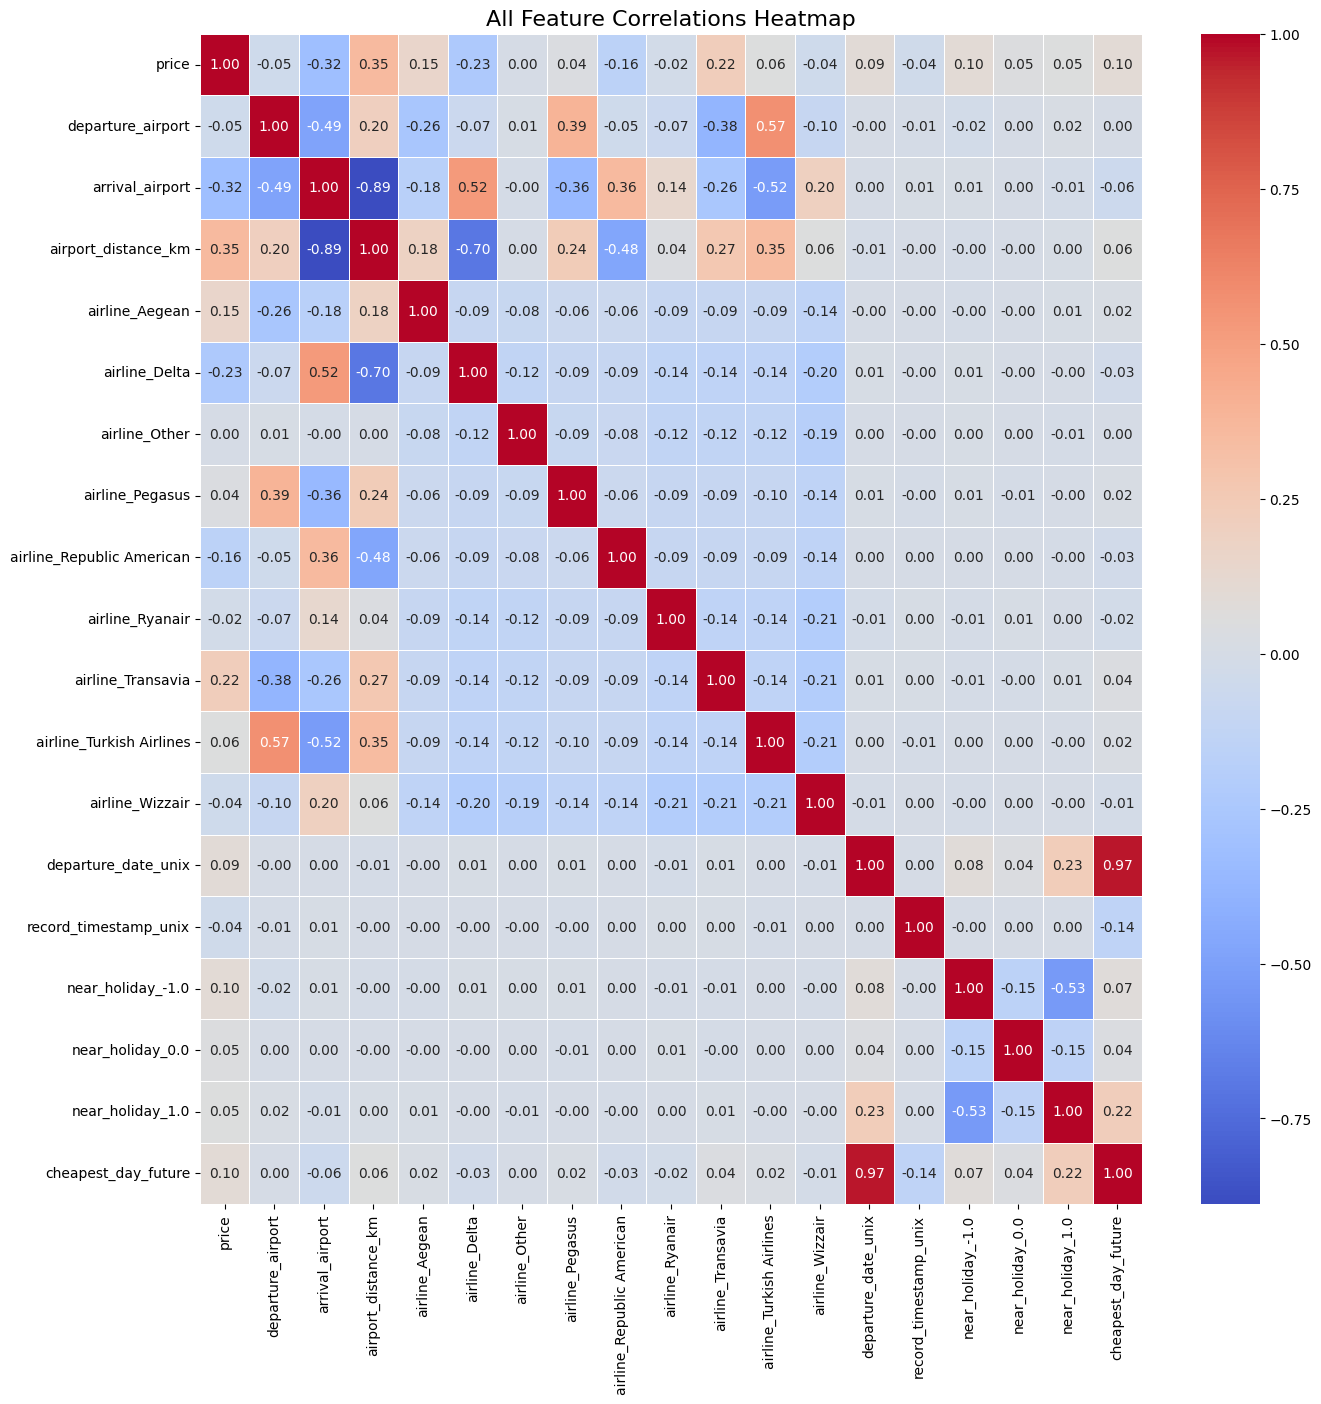

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

correlations = main_data.corr()

plt.figure(figsize=(min(20, 0.8 * len(correlations)), min(20, 0.8 * len(correlations))))  

sns.heatmap(
    correlations, 
    annot=True, 
    fmt=".2f",
    linewidths=0.5,
    cmap="coolwarm",
)

plt.title("All Feature Correlations Heatmap", fontsize=16)
plt.show()

In [6]:
correlation_target = main_data.corr()['cheapest_day_future'].sort_values(ascending=False)
print(correlation_target)

cheapest_day_future          1.000000
departure_date_unix          0.970485
near_holiday_1.0             0.220311
price                        0.099999
near_holiday_-1.0            0.073225
airport_distance_km          0.055385
near_holiday_0.0             0.039286
airline_Transavia            0.035393
airline_Turkish Airlines     0.021107
airline_Pegasus              0.018002
airline_Aegean               0.017024
departure_airport            0.003540
airline_Other                0.001743
airline_Wizzair             -0.013048
airline_Ryanair             -0.018270
airline_Republic American   -0.025639
airline_Delta               -0.030473
arrival_airport             -0.057429
record_timestamp_unix       -0.141530
Name: cheapest_day_future, dtype: float64


We can see that generally the correlations are low, but lets select the ones with highest absolute value

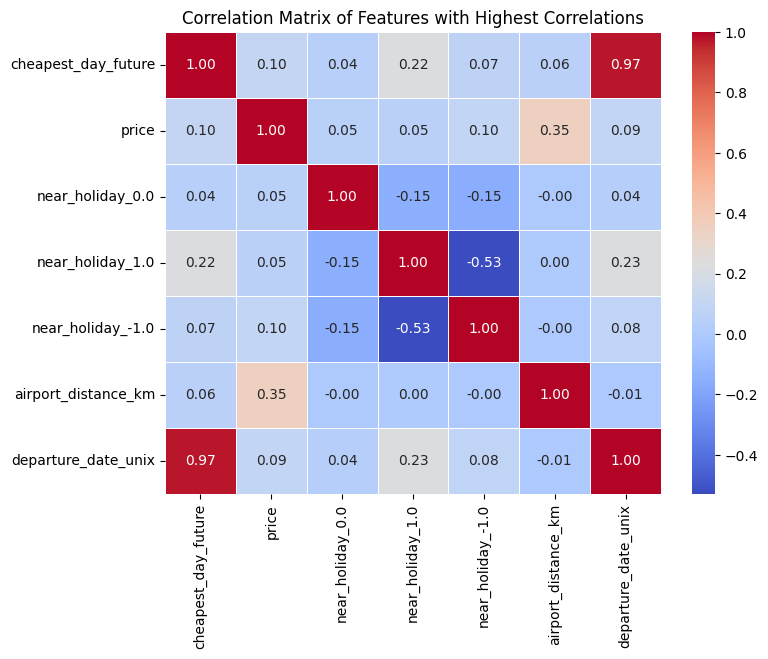

In [7]:
most_important_columns = ['cheapest_day_future', 'price', 'near_holiday_0.0','near_holiday_1.0','near_holiday_-1.0', 'airport_distance_km', 'departure_date_unix']
correlation_matrix = main_data[most_important_columns].corr()

# Plot heatmap to visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features with Highest Correlations")
plt.show()

In [8]:
# Define the target and parameters
target = 'cheapest_day_future'

X = main_data[['price', 'near_holiday_0.0','near_holiday_1.0','near_holiday_-1.0', 'airport_distance_km', 'departure_date_unix']]
y = main_data[target]

### 🪓 Splitting into train/test
80% of the data is used for training, and 20% for testing

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

X_train

There are in total 59013 observations, of which 47210 are now in the train set, and 11803 in the test set.


,price,near_holiday_0.0,near_holiday_1.0,near_holiday_-1.0,airport_distance_km,departure_date_unix
55068,235,False,True,False,1658.335311,1758758400
45352,85,True,False,False,2067.423123,1755993600
4946,79,False,False,False,1658.335311,1744243200
263,73,False,False,False,328.393017,1742774400
57800,60,False,False,True,1658.335311,1759536000
...,...,...,...,...,...,...
57089,97,False,False,False,2067.423123,1759363200
34848,124,False,True,False,328.393017,1752883200
1350,121,False,False,False,2211.947562,1743120000
27915,102,False,False,False,328.393017,1750896000


# 🧬 Modelling

`k Nearest Neighbour` will be used at these first stages of the development

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the KNeighborsRegressor model
knn = KNeighborsClassifier()

# Fit the model on the training data
knn.fit(X_train, y_train)

# Predict the target values on the test set
pred = knn.predict(X_test)

# 🔬 Evaluation
In order to shed some light on the results a classification report can be printed. 

In [11]:

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 4.2041853765991695
Root Mean Squared Error (RMSE): 9.741868786620541
R² Score: 0.9724462039952186


After many different attempts at data cleaning/changing/adding new features, the KNN does not seem to do a good job on predicting the actual category of the cheapest day, lets switch to a more suitable algorhitm.

## 🆕 Model change -> Linear Regression

Going back to othe original dataset before categorising the target variable

## 🎯 Target Variable


Now I will try with the actual and most accurate target variable - daysAgo for a flight

### 💡 Feature Selection


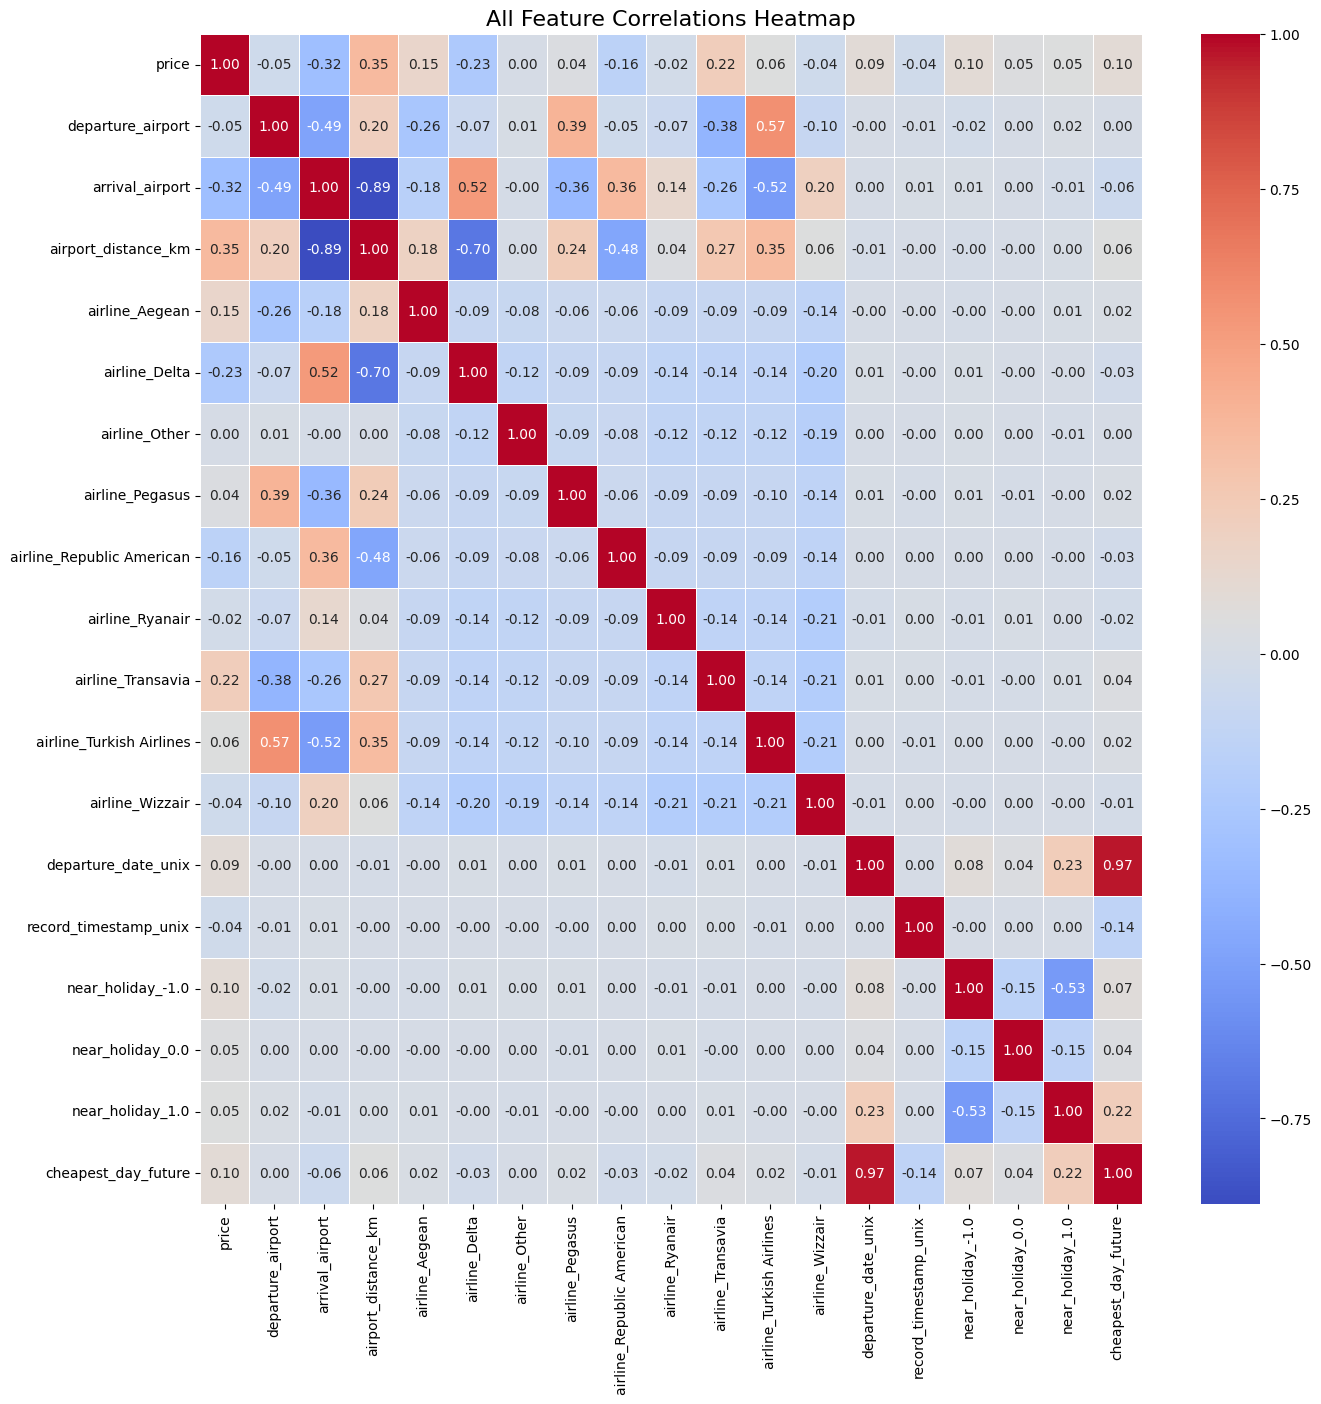

In [12]:
correlations = main_data.corr()

plt.figure(figsize=(min(20, 0.8 * len(correlations)), min(20, 0.8 * len(correlations))))  

sns.heatmap(
    correlations, 
    annot=True, 
    fmt=".2f",
    linewidths=0.5,
    cmap="coolwarm",
)

plt.title("All Feature Correlations Heatmap", fontsize=16)
plt.show()

Now we have greater correlelation between the target and other features, compared to the categorical target variable

Correlation of most important features, where the correlations is above 0.07

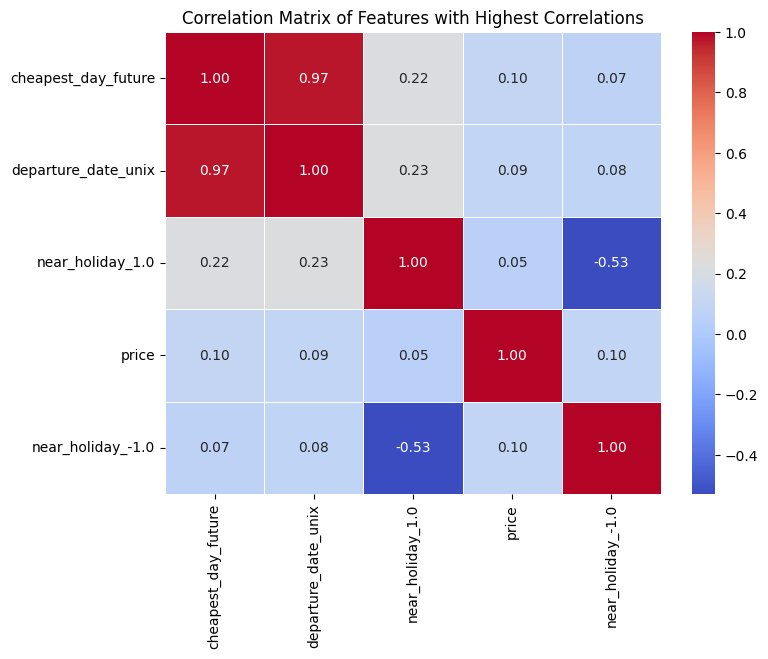

In [13]:
most_important_columns = ['cheapest_day_future', 'departure_date_unix','near_holiday_1.0','price', 'near_holiday_-1.0']
correlation_matrix = main_data[most_important_columns].corr()

# Plot heatmap to visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features with Highest Correlations")
plt.show()

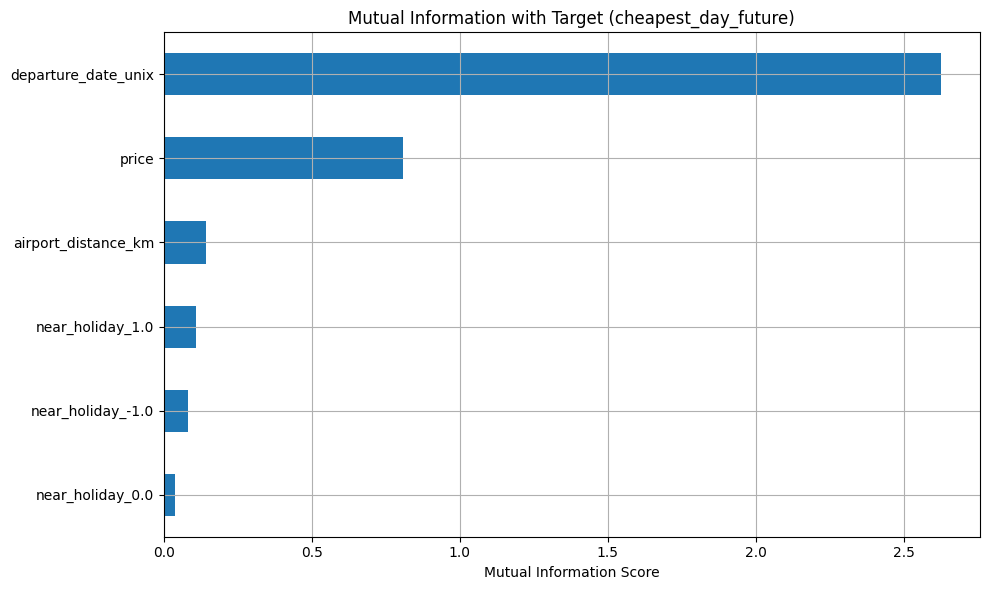

In [14]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

# Encode any categorical columns (if not already encoded)
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include='object').columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

# Calculate mutual information
mi_scores = mutual_info_regression(X_encoded, y)
mi_series = pd.Series(mi_scores, index=X_encoded.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
mi_series.plot(kind='barh')
plt.title('Mutual Information with Target (cheapest_day_future)')
plt.xlabel('Mutual Information Score')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

### 🪓 Splitting into train/test
80% of the data is used for training, and 20% for testing

In [15]:
# Define the target and parameters
target = 'cheapest_day_future'
params = [
    'price',
    'airport_distance_km',
    'near_holiday_-1.0',
    'near_holiday_0.0',
    'near_holiday_1.0',
    'departure_airport',
    'arrival_airport']

X = main_data[params]
y = main_data[target]

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

X_train

There are in total 59013 observations, of which 47210 are now in the train set, and 11803 in the test set.


,price,airport_distance_km,near_holiday_-1.0,near_holiday_0.0,near_holiday_1.0,departure_airport,arrival_airport
35444,52,328.393017,False,True,False,1,4
35859,79,2211.947562,False,False,True,3,0
5600,62,328.393017,True,False,False,1,4
27743,63,2211.947562,False,False,False,3,0
42600,225,1658.335311,False,True,False,2,2
...,...,...,...,...,...,...,...
44286,45,328.393017,True,False,False,1,4
51377,107,2067.423123,False,False,True,0,1
6380,80,1658.335311,True,False,False,0,3
46300,64,2067.423123,False,False,True,0,1


# 🧬 Modelling

`Linear Regression` will be used for the iteration 1 attempt

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the Linear Regression model
lr = LinearRegression()

# Fit the model on the training data
lr.fit(X_train, y_train)

# Predict the target values on the test set
pred = lr.predict(X_test)

# 🔬 Evaluation
In order to shed some light on the results a classification report can be printed. 

In [18]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 45.25636715708361
Root Mean Squared Error (RMSE): 54.743731117609904
R² Score: 0.12654555254604438


Wow! The R2 Score is 1. The model seems to be very good, however that does not always that the predictions will be correct. Lets test it out

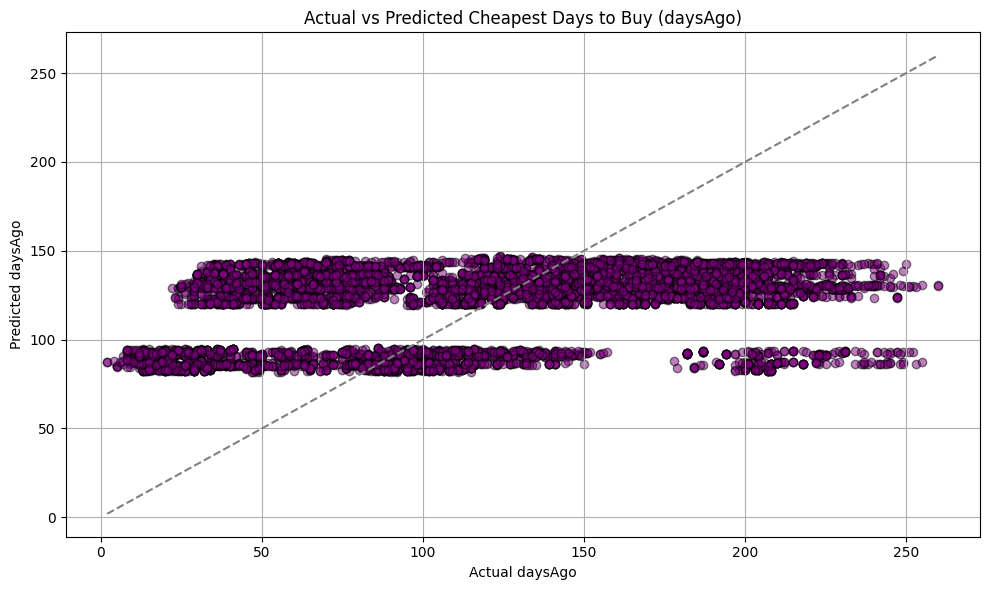

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Scatter plot: Actual vs Predicted
plt.scatter(y_test, pred, alpha=0.5, color='purple', edgecolors='k')

# Add a reference line (perfect predictions)
min_val = min(min(y_test), min(pred))
max_val = max(max(y_test), max(pred))
plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--')

plt.xlabel('Actual daysAgo')
plt.ylabel('Predicted daysAgo')
plt.title('Actual vs Predicted Cheapest Days to Buy (daysAgo)')
plt.grid(True)
plt.tight_layout()
plt.show()

The scatter plot of Actual vs Predicted looks excellent — the points fall almost perfectly on the red dashed line (which represents perfect predictions). This suggests that my model is doing an outstanding job. However, it shouldn't be a straight line, lets keep on testing to see where the problem is.

In [20]:
import pandas as pd

comparison = pd.DataFrame({
    'Actual': y_test[:20],
    'Predicted': pred[:20],
    'Residual': y_test[:20] - pred[:20]
})
print(comparison)

       Actual   Predicted    Residual
7487       39  132.695788  -93.695788
30444     135  128.376557    6.623443
18057      74  129.747584  -55.747584
33406     132  123.254522    8.745478
34394     171  132.284855   38.715145
51552     191  137.886558   53.113442
32509     122  135.890601  -13.890601
57092     249   93.050986  155.949014
45553     190  127.129027   62.870973
47773     206  142.690159   63.309841
49020     173  123.655988   49.344012
22149     108   86.506133   21.493867
34820     133  134.078175   -1.078175
8207       43  125.205393  -82.205393
34637     149  140.601703    8.398297
15169      63   94.107669  -31.107669
15046      85   85.546973   -0.546973
50692     176  136.800523   39.199477
21523      85   89.734887   -4.734887
20398     101   83.147500   17.852500


In [21]:
target = 'cheapest_day_future'
params = [
    'price',
    'airport_distance_km',
    'near_holiday_-1.0',
    'near_holiday_0.0',
    'near_holiday_1.0',
    'departure_airport',
    'arrival_airport',
]

X = main_data[params]
y = main_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)